<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab13and14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB 13 - **Towards self-attention**
## *Last homework: finding odd shapes*
###**AUTHOR**: Gloria Rivas

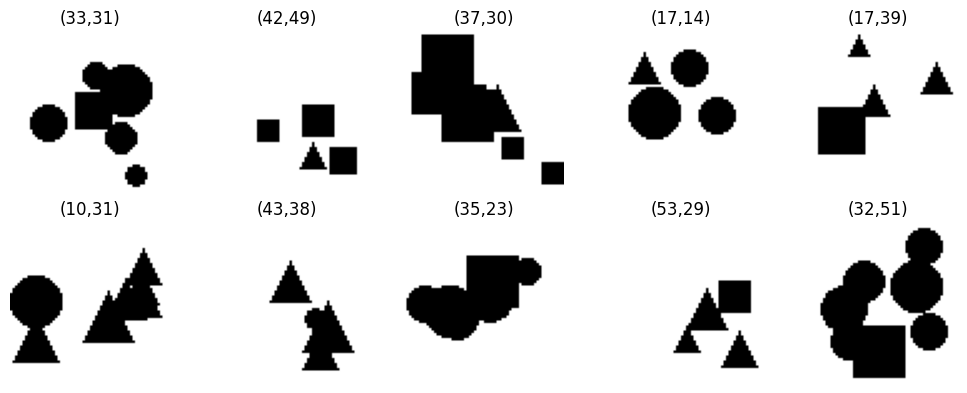

In [1]:
# ============================================================
# 0. Imports & device
# ============================================================
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

##STEP 1: Embedding

In [2]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    """
    Converts a [B, 1, 64, 64] image into [B, 144, 16] patch embeddings
    using a single convolution layer.
    """
    def __init__(self):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=1, out_channels=16,
            kernel_size=20, stride=4, padding=0
        )

    def forward(self, x):
        """
        x: [B, 1, 64, 64]
        returns: [B, 144, 16]
        """
        x = self.proj(x)                   # [B, 16, 12, 12]
        x = x.flatten(2)                   # [B, 16, 144]
        x = x.transpose(1, 2)              # [B, 144, 16]
        return x


Example of usage:

In [3]:
model = PatchEmbedding()
dummy_input = torch.randn(8, 1, 64, 64)
out = model(dummy_input)
print(out.shape)


torch.Size([8, 144, 16])


##STEP 2: Sinusoidal Positional Encoding

In [4]:
import math

class PositionalEncoding(nn.Module):
    """
    Adds sinusoidal positional encoding to patch embeddings.

    Input:  [B, 144, 16]
    Output: [B, 144, 16]
    """
    def __init__(self, num_positions=144, d_model=16):
        super().__init__()
        self.encoding = self._build_encoding(num_positions, d_model)  # [144, 16]
        self.encoding = self.encoding.unsqueeze(0)  # [1, 144, 16]

    def _build_encoding(self, num_positions, d_model):
        pe = torch.zeros(num_positions, d_model)
        position = torch.arange(0, num_positions).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        return pe

    def forward(self, x):
        """
        x: [B, 144, 16]
        return: [B, 144, 16]
        """
        return x + self.encoding.to(x.device)


Example usage:

In [5]:
embedder = PatchEmbedding()
pos_enc = PositionalEncoding()

dummy_input = torch.randn(8, 1, 64, 64)
x = embedder(dummy_input)        # [8, 144, 16]
x = pos_enc(x)                   # [8, 144, 16] + positional encoding

##STEP 3 - Attention

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.scale = dim ** -0.5
        self.attn_weights = None  # <-- store for visualization

    def forward(self, x):  # x: [B, N=144, D]
        Q = self.to_q(x)  # [B, N, D]
        K = self.to_k(x)  # [B, N, D]
        V = self.to_v(x)  # [B, N, D]

        attn_logits = Q @ K.transpose(-2, -1) * self.scale  # [B, N, N]
        attn = attn_logits.softmax(dim=-1)                 # [B, N, N]

        self.attn_weights = attn.detach().cpu()

        return attn @ V                    # [B, N, D]



Example usage:

In [7]:
embed = PatchEmbedding()
posenc = PositionalEncoding()
attn   = SelfAttention()

x = embed(torch.randn(4, 1, 64, 64))   # [4, 144, 16]
x = posenc(x)                          # [4, 144, 16]
x = attn(x)                            # [4, 144, 16]


##STEP 4 - Post-Processing via a Token-Wise Classifier.

In [8]:
class TokenClassifier(nn.Module):
    """
    Classifies each of the 144 tokens independently with a deeper MLP.
    Input:  [B, 144, 16]
    Output: [B, 144] (logits)
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(16, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 1 logit per token
        )

    def forward(self, x):
        logits = self.net(x)         # [B, 144, 1]
        return logits.squeeze(-1)    # [B, 144]

Example usage:

In [9]:
embedder = PatchEmbedding()
posenc = PositionalEncoding()
attention = SelfAttention()
classifier = TokenClassifier()

img = torch.randn(4, 1, 64, 64)
x = classifier(attention(posenc(embedder(img))))  # [4, 144]

# Convert to softmax probabilities
probs = torch.softmax(x, dim=-1)  # [4, 144]
print("Per-position probabilities shape:", probs.shape)


Per-position probabilities shape: torch.Size([4, 144])


##STEP 5 - Soft Argmax

In [10]:
def compute_patch_centers(image_size=64, patch_size=20, stride=4):
    centers = []
    for y in range(0, image_size - patch_size + 1, stride):
        for x in range(0, image_size - patch_size + 1, stride):
            cx = x + patch_size // 2
            cy = y + patch_size // 2
            centers.append((cx, cy))
    return torch.tensor(centers, dtype=torch.float32)  # [144, 2]


def soft_argmax(probabilities, centers):
    """
    Args:
        probabilities: [B, 144] - softmaxed logits
        centers: [144, 2]       - (cx, cy) per patch
    Returns:
        coords: [B, 2] - predicted (x, y)
    """
    B = probabilities.shape[0]
    weighted = torch.einsum('bn,nc->bc', probabilities, centers.to(probabilities.device))
    return weighted  # [B, 2]


Example usage:

In [11]:
centers = compute_patch_centers()  # [144, 2]
pred_coords = soft_argmax(probs, centers)  # [B, 2]
print("Predicted (x, y) locations:", pred_coords)


Predicted (x, y) locations: tensor([[31.9994, 31.9964],
        [32.0013, 31.9967],
        [31.9996, 31.9974],
        [31.9987, 31.9956]], grad_fn=<ViewBackward0>)


##**MODEL PREPARING**

In [12]:
class ShapeAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = PatchEmbedding()               # [B, 1, 64, 64] → [B, 144, 16]
        self.pos_enc = PositionalEncoding()             # [B, 144, 16] + pos
        self.attn = SelfAttention()                     # → [B, 144, 16]
        self.classifier = TokenClassifier()             # → [B, 144] (logits)

        # Precompute receptive field centers (used in soft argmax)
        self.centers = compute_patch_centers()          # [144, 2]

    def forward(self, x):
        """
        x: [B, 1, 64, 64]
        Returns:
            coords: [B, 2] — predicted (x, y) position
        """
        x = self.embedding(x)                           # [B, 144, 16]
        x = self.pos_enc(x)                             # [B, 144, 16]
        x = self.attn(x)                                # [B, 144, 16]
        logits = self.classifier(x)                     # [B, 144]
        probs = torch.softmax(logits, dim=-1)           # [B, 144]
        pred_coords = soft_argmax(probs, self.centers)  # [B, 2]
        return pred_coords


##**TRAINING STEP**

In [13]:
import torch.optim as optim
import random
from torch.utils.data import DataLoader
from tqdm import tqdm

SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = ShapeAttentionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_dataset = OddXYDataset(num_samples=20000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [14]:
def train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

    return loss_history


Epoch 1/80: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 1 — Avg Loss: 184.0623


Epoch 2/80: 100%|██████████| 313/313 [00:20<00:00, 15.42it/s]


Epoch 2 — Avg Loss: 180.2138


Epoch 3/80: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


Epoch 3 — Avg Loss: 176.0088


Epoch 4/80: 100%|██████████| 313/313 [00:21<00:00, 14.76it/s]


Epoch 4 — Avg Loss: 164.2994


Epoch 5/80: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 5 — Avg Loss: 156.4853


Epoch 6/80: 100%|██████████| 313/313 [00:19<00:00, 16.33it/s]


Epoch 6 — Avg Loss: 150.3604


Epoch 7/80: 100%|██████████| 313/313 [00:20<00:00, 15.32it/s]


Epoch 7 — Avg Loss: 144.8861


Epoch 8/80: 100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


Epoch 8 — Avg Loss: 140.1277


Epoch 9/80: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 9 — Avg Loss: 137.9244


Epoch 10/80: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s]


Epoch 10 — Avg Loss: 131.5063


Epoch 11/80: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 11 — Avg Loss: 130.2190


Epoch 12/80: 100%|██████████| 313/313 [00:19<00:00, 16.32it/s]


Epoch 12 — Avg Loss: 125.3355


Epoch 13/80: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 13 — Avg Loss: 121.9008


Epoch 14/80: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s]


Epoch 14 — Avg Loss: 119.5207


Epoch 15/80: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 15 — Avg Loss: 119.5946


Epoch 16/80: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s]


Epoch 16 — Avg Loss: 113.5623


Epoch 17/80: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 17 — Avg Loss: 116.0409


Epoch 18/80: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s]


Epoch 18 — Avg Loss: 113.0544


Epoch 19/80: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s]


Epoch 19 — Avg Loss: 115.0633


Epoch 20/80: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 20 — Avg Loss: 110.0561


Epoch 21/80: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 21 — Avg Loss: 111.3183


Epoch 22/80: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 22 — Avg Loss: 109.8226


Epoch 23/80: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 23 — Avg Loss: 106.8060


Epoch 24/80: 100%|██████████| 313/313 [00:20<00:00, 15.53it/s]


Epoch 24 — Avg Loss: 104.7470


Epoch 25/80: 100%|██████████| 313/313 [00:19<00:00, 16.34it/s]


Epoch 25 — Avg Loss: 104.7634


Epoch 26/80: 100%|██████████| 313/313 [00:20<00:00, 15.61it/s]


Epoch 26 — Avg Loss: 104.0006


Epoch 27/80: 100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


Epoch 27 — Avg Loss: 104.6133


Epoch 28/80: 100%|██████████| 313/313 [00:20<00:00, 15.59it/s]


Epoch 28 — Avg Loss: 105.1134


Epoch 29/80: 100%|██████████| 313/313 [00:19<00:00, 16.25it/s]


Epoch 29 — Avg Loss: 102.3679


Epoch 30/80: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 30 — Avg Loss: 100.0324


Epoch 31/80: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 31 — Avg Loss: 100.6228


Epoch 32/80: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 32 — Avg Loss: 99.0769


Epoch 33/80: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 33 — Avg Loss: 97.8259


Epoch 34/80: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 34 — Avg Loss: 100.5780


Epoch 35/80: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 35 — Avg Loss: 96.7299


Epoch 36/80: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 36 — Avg Loss: 95.6747


Epoch 37/80: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 37 — Avg Loss: 96.5020


Epoch 38/80: 100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


Epoch 38 — Avg Loss: 94.8949


Epoch 39/80: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 39 — Avg Loss: 94.4530


Epoch 40/80: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 40 — Avg Loss: 95.5994


Epoch 41/80: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 41 — Avg Loss: 93.8097


Epoch 42/80: 100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


Epoch 42 — Avg Loss: 92.7781


Epoch 43/80: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s]


Epoch 43 — Avg Loss: 91.7049


Epoch 44/80: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 44 — Avg Loss: 92.3964


Epoch 45/80: 100%|██████████| 313/313 [00:20<00:00, 15.44it/s]


Epoch 45 — Avg Loss: 93.7006


Epoch 46/80: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch 46 — Avg Loss: 91.5680


Epoch 47/80: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 47 — Avg Loss: 91.7685


Epoch 48/80: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 48 — Avg Loss: 90.1142


Epoch 49/80: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 49 — Avg Loss: 90.7641


Epoch 50/80: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 50 — Avg Loss: 88.8179


Epoch 51/80: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 51 — Avg Loss: 89.8300


Epoch 52/80: 100%|██████████| 313/313 [00:20<00:00, 15.40it/s]


Epoch 52 — Avg Loss: 88.4257


Epoch 53/80: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


Epoch 53 — Avg Loss: 88.2606


Epoch 54/80: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 54 — Avg Loss: 86.5572


Epoch 55/80: 100%|██████████| 313/313 [00:18<00:00, 16.66it/s]


Epoch 55 — Avg Loss: 87.5297


Epoch 56/80: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 56 — Avg Loss: 87.9014


Epoch 57/80: 100%|██████████| 313/313 [00:18<00:00, 16.64it/s]


Epoch 57 — Avg Loss: 87.0287


Epoch 58/80: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch 58 — Avg Loss: 86.3735


Epoch 59/80: 100%|██████████| 313/313 [00:18<00:00, 16.84it/s]


Epoch 59 — Avg Loss: 85.8516


Epoch 60/80: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 60 — Avg Loss: 88.4614


Epoch 61/80: 100%|██████████| 313/313 [00:18<00:00, 17.12it/s]


Epoch 61 — Avg Loss: 83.4581


Epoch 62/80: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s]


Epoch 62 — Avg Loss: 85.7211


Epoch 63/80: 100%|██████████| 313/313 [00:18<00:00, 17.19it/s]


Epoch 63 — Avg Loss: 85.0161


Epoch 64/80: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s]


Epoch 64 — Avg Loss: 84.1312


Epoch 65/80: 100%|██████████| 313/313 [00:18<00:00, 16.94it/s]


Epoch 65 — Avg Loss: 83.8174


Epoch 66/80: 100%|██████████| 313/313 [00:18<00:00, 16.87it/s]


Epoch 66 — Avg Loss: 82.4559


Epoch 67/80: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s]


Epoch 67 — Avg Loss: 82.1698


Epoch 68/80: 100%|██████████| 313/313 [00:18<00:00, 17.18it/s]


Epoch 68 — Avg Loss: 83.8588


Epoch 69/80: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


Epoch 69 — Avg Loss: 82.3778


Epoch 70/80: 100%|██████████| 313/313 [00:18<00:00, 16.88it/s]


Epoch 70 — Avg Loss: 82.8101


Epoch 71/80: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 71 — Avg Loss: 79.9502


Epoch 72/80: 100%|██████████| 313/313 [00:18<00:00, 16.99it/s]


Epoch 72 — Avg Loss: 81.9560


Epoch 73/80: 100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


Epoch 73 — Avg Loss: 80.0168


Epoch 74/80: 100%|██████████| 313/313 [00:18<00:00, 17.04it/s]


Epoch 74 — Avg Loss: 79.8718


Epoch 75/80: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 75 — Avg Loss: 78.6326


Epoch 76/80: 100%|██████████| 313/313 [00:18<00:00, 17.16it/s]


Epoch 76 — Avg Loss: 78.1155


Epoch 77/80: 100%|██████████| 313/313 [00:19<00:00, 16.40it/s]


Epoch 77 — Avg Loss: 78.6390


Epoch 78/80: 100%|██████████| 313/313 [00:18<00:00, 16.97it/s]


Epoch 78 — Avg Loss: 78.9141


Epoch 79/80: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 79 — Avg Loss: 76.2489


Epoch 80/80: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s]


Epoch 80 — Avg Loss: 77.5745


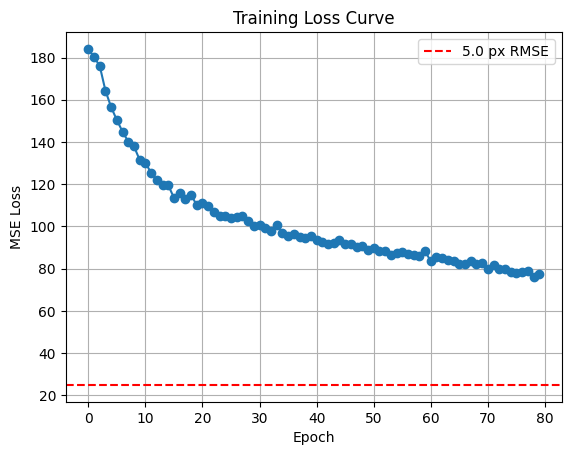

In [15]:
import matplotlib.pyplot as plt

losses = train(model, train_loader, optimizer, criterion, epochs=80)


plt.plot(losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.axhline(y=25, color='red', linestyle='--', label='5.0 px RMSE')
plt.legend()
plt.grid(True)
plt.show()


##**EVALUATION**

In [16]:
def evaluate(model, num_samples=1000):
    model.eval()
    test_dataset = OddXYDataset(num_samples)
    test_loader = DataLoader(test_dataset, batch_size=64)

    errors = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            error = torch.sqrt(((preds - labels) ** 2).sum(dim=1))
            errors.extend(error.cpu().numpy())

    rmse = np.mean(errors)
    print(f"Test RMSE: {rmse:.3f} pixels")
    return rmse

evaluate(model, num_samples=1000)


Test RMSE: 9.976 pixels


np.float32(9.975927)

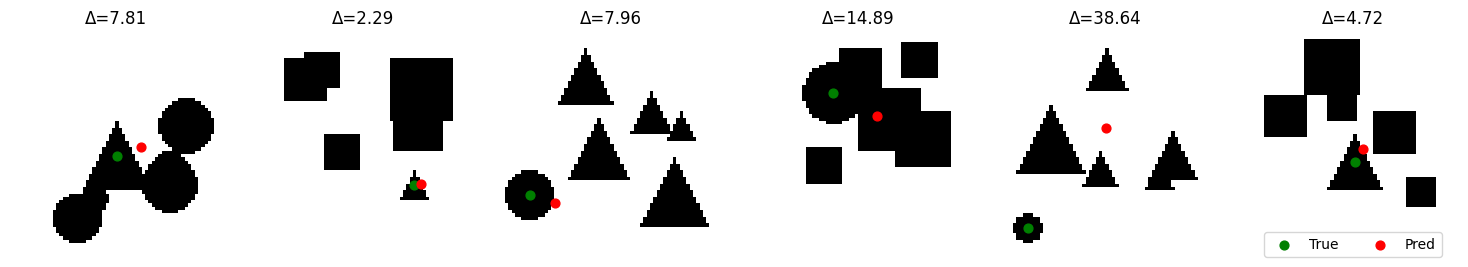

In [17]:
def visualize_predictions(model, dataset, num_examples=6):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_examples)
    images, labels = next(iter(loader))
    preds = model(images.to(device)).cpu().detach()

    fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 2.5, 2.5))

    for i in range(num_examples):
        img = images[i].squeeze().numpy()
        true_x, true_y = labels[i]
        pred_x, pred_y = preds[i]

        axes[i].imshow(img, cmap="gray")
        axes[i].scatter(true_x, true_y, c="green", label="True", s=40)
        axes[i].scatter(pred_x, pred_y, c="red", label="Pred", s=40)
        axes[i].set_title(f"Δ={((pred_x-true_x)**2+(pred_y-true_y)**2).sqrt():.2f}")
        axes[i].axis("off")

    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, OddXYDataset(num_samples=100))

#**TEXTUAL DESCRIPTION**

By the training loss curve, we can say that this result shows that while the model learns reasonably well and reduces the loss over time, the performance is not yet sufficient for the benchmark goal (RMSE ≤ 5.0 pixels). A model modification or architectural refinement is needed to cross this threshold.

These visualizations confirm that the model can identify the odd object in many cases but occasionally fails completely. The large error in sample #4 highlights a key issue — the model might lack the fine-grained resolution to localize the object accurately, or struggles when the odd shape is near field boundaries. This reinforces the need for improvements like adding the offset regressor to predict sub-token corrections or adjusting the attention mechanism.

##**OFFSET REGRESSOR**

In [18]:
class OffsetRegressor(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(16, 128),
          nn.ReLU(),
          nn.Linear(128, 2)
          )  # (Δx, Δy)


    def forward(self, x):  # x: [B, 144, 16]
        return self.net(x)  # [B, 144, 2]


##**NEW MODEL**

In [19]:
class ShapeAttentionModelV2(nn.Module):
    def __init__(self, pretrained_model=None):
        super().__init__()
        self.embedding = PatchEmbedding()
        self.pos_enc = PositionalEncoding()
        self.attn = SelfAttention()
        self.classifier = TokenClassifier()
        self.offset_head = OffsetRegressor()

        self.centers = compute_patch_centers()  # [144, 2]

        if pretrained_model:  # ← from phase 1
            self.embedding.load_state_dict(pretrained_model.embedding.state_dict())
            self.pos_enc.load_state_dict(pretrained_model.pos_enc.state_dict())
            self.attn.load_state_dict(pretrained_model.attn.state_dict())
            self.classifier.load_state_dict(pretrained_model.classifier.state_dict())

    def forward(self, x):
        x = self.embedding(x)               # [B, 144, 16]
        x = self.pos_enc(x)
        x = self.attn(x)

        logits = self.classifier(x)         # [B, 144]
        probs = torch.softmax(logits, dim=-1)  # [B, 144]

        coarse = soft_argmax(probs, self.centers)  # [B, 2]

        offsets = self.offset_head(x)       # [B, 144, 2]
        weighted_offset = torch.sum(probs.unsqueeze(-1) * offsets, dim=1)  # [B, 2]

        return coarse + weighted_offset     # Final prediction


In [20]:
model_v2 = ShapeAttentionModelV2(pretrained_model=model).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=1e-3)
train_dataset = OddXYDataset(num_samples=20000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

losses2 = train(model_v2, train_loader, optimizer, criterion, epochs=80)


Epoch 1/80: 100%|██████████| 313/313 [00:21<00:00, 14.42it/s]


Epoch 1 — Avg Loss: 79.9852


Epoch 2/80: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


Epoch 2 — Avg Loss: 78.8645


Epoch 3/80: 100%|██████████| 313/313 [00:20<00:00, 15.20it/s]


Epoch 3 — Avg Loss: 75.8352


Epoch 4/80: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


Epoch 4 — Avg Loss: 73.7615


Epoch 5/80: 100%|██████████| 313/313 [00:22<00:00, 14.04it/s]


Epoch 5 — Avg Loss: 76.0042


Epoch 6/80: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


Epoch 6 — Avg Loss: 76.1518


Epoch 7/80: 100%|██████████| 313/313 [00:22<00:00, 13.91it/s]


Epoch 7 — Avg Loss: 73.6841


Epoch 8/80: 100%|██████████| 313/313 [00:22<00:00, 14.05it/s]


Epoch 8 — Avg Loss: 77.6884


Epoch 9/80: 100%|██████████| 313/313 [00:22<00:00, 13.84it/s]


Epoch 9 — Avg Loss: 75.8636


Epoch 10/80: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s]


Epoch 10 — Avg Loss: 73.0440


Epoch 11/80: 100%|██████████| 313/313 [00:22<00:00, 13.93it/s]


Epoch 11 — Avg Loss: 74.1565


Epoch 12/80: 100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


Epoch 12 — Avg Loss: 73.0868


Epoch 13/80: 100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch 13 — Avg Loss: 74.0541


Epoch 14/80: 100%|██████████| 313/313 [00:21<00:00, 14.31it/s]


Epoch 14 — Avg Loss: 71.6494


Epoch 15/80: 100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch 15 — Avg Loss: 73.3373


Epoch 16/80: 100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 16 — Avg Loss: 73.5304


Epoch 17/80: 100%|██████████| 313/313 [00:22<00:00, 13.98it/s]


Epoch 17 — Avg Loss: 71.8638


Epoch 18/80: 100%|██████████| 313/313 [00:21<00:00, 14.61it/s]


Epoch 18 — Avg Loss: 72.2274


Epoch 19/80: 100%|██████████| 313/313 [00:22<00:00, 13.84it/s]


Epoch 19 — Avg Loss: 71.6860


Epoch 20/80: 100%|██████████| 313/313 [00:22<00:00, 13.78it/s]


Epoch 20 — Avg Loss: 72.7438


Epoch 21/80: 100%|██████████| 313/313 [00:22<00:00, 13.74it/s]


Epoch 21 — Avg Loss: 69.4782


Epoch 22/80: 100%|██████████| 313/313 [00:21<00:00, 14.44it/s]


Epoch 22 — Avg Loss: 71.9045


Epoch 23/80: 100%|██████████| 313/313 [00:22<00:00, 13.76it/s]


Epoch 23 — Avg Loss: 70.4218


Epoch 24/80: 100%|██████████| 313/313 [00:22<00:00, 13.85it/s]


Epoch 24 — Avg Loss: 69.2026


Epoch 25/80: 100%|██████████| 313/313 [00:22<00:00, 14.02it/s]


Epoch 25 — Avg Loss: 71.2803


Epoch 26/80: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch 26 — Avg Loss: 71.5386


Epoch 27/80: 100%|██████████| 313/313 [00:22<00:00, 13.96it/s]


Epoch 27 — Avg Loss: 70.6178


Epoch 28/80: 100%|██████████| 313/313 [00:22<00:00, 13.93it/s]


Epoch 28 — Avg Loss: 70.7160


Epoch 29/80: 100%|██████████| 313/313 [00:22<00:00, 14.18it/s]


Epoch 29 — Avg Loss: 71.2075


Epoch 30/80: 100%|██████████| 313/313 [00:21<00:00, 14.55it/s]


Epoch 30 — Avg Loss: 68.6119


Epoch 31/80: 100%|██████████| 313/313 [00:22<00:00, 14.13it/s]


Epoch 31 — Avg Loss: 68.6878


Epoch 32/80: 100%|██████████| 313/313 [00:22<00:00, 14.11it/s]


Epoch 32 — Avg Loss: 69.9455


Epoch 33/80: 100%|██████████| 313/313 [00:21<00:00, 14.42it/s]


Epoch 33 — Avg Loss: 70.0827


Epoch 34/80: 100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Epoch 34 — Avg Loss: 71.4476


Epoch 35/80: 100%|██████████| 313/313 [00:22<00:00, 13.77it/s]


Epoch 35 — Avg Loss: 69.3806


Epoch 36/80: 100%|██████████| 313/313 [00:22<00:00, 13.70it/s]


Epoch 36 — Avg Loss: 67.3170


Epoch 37/80: 100%|██████████| 313/313 [00:21<00:00, 14.32it/s]


Epoch 37 — Avg Loss: 69.3585


Epoch 38/80: 100%|██████████| 313/313 [00:22<00:00, 14.10it/s]


Epoch 38 — Avg Loss: 67.6861


Epoch 39/80: 100%|██████████| 313/313 [00:22<00:00, 13.86it/s]


Epoch 39 — Avg Loss: 68.5303


Epoch 40/80: 100%|██████████| 313/313 [00:22<00:00, 13.99it/s]


Epoch 40 — Avg Loss: 69.4592


Epoch 41/80: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


Epoch 41 — Avg Loss: 67.5393


Epoch 42/80: 100%|██████████| 313/313 [00:22<00:00, 14.13it/s]


Epoch 42 — Avg Loss: 66.7057


Epoch 43/80: 100%|██████████| 313/313 [00:22<00:00, 13.94it/s]


Epoch 43 — Avg Loss: 68.8509


Epoch 44/80: 100%|██████████| 313/313 [00:22<00:00, 14.04it/s]


Epoch 44 — Avg Loss: 68.6007


Epoch 45/80: 100%|██████████| 313/313 [00:21<00:00, 14.51it/s]


Epoch 45 — Avg Loss: 68.0769


Epoch 46/80: 100%|██████████| 313/313 [00:22<00:00, 13.86it/s]


Epoch 46 — Avg Loss: 67.6700


Epoch 47/80: 100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


Epoch 47 — Avg Loss: 69.6395


Epoch 48/80: 100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch 48 — Avg Loss: 67.6824


Epoch 49/80: 100%|██████████| 313/313 [00:22<00:00, 14.14it/s]


Epoch 49 — Avg Loss: 67.7636


Epoch 50/80: 100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch 50 — Avg Loss: 67.6489


Epoch 51/80: 100%|██████████| 313/313 [00:22<00:00, 13.75it/s]


Epoch 51 — Avg Loss: 67.1384


Epoch 52/80: 100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


Epoch 52 — Avg Loss: 67.0669


Epoch 53/80: 100%|██████████| 313/313 [00:22<00:00, 14.05it/s]


Epoch 53 — Avg Loss: 68.5899


Epoch 54/80: 100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


Epoch 54 — Avg Loss: 70.0009


Epoch 55/80: 100%|██████████| 313/313 [00:22<00:00, 13.64it/s]


Epoch 55 — Avg Loss: 63.7063


Epoch 56/80: 100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 56 — Avg Loss: 63.6717


Epoch 57/80: 100%|██████████| 313/313 [00:22<00:00, 13.96it/s]


Epoch 57 — Avg Loss: 65.6629


Epoch 58/80: 100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 58 — Avg Loss: 65.6857


Epoch 59/80: 100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


Epoch 59 — Avg Loss: 68.8846


Epoch 60/80: 100%|██████████| 313/313 [00:22<00:00, 13.69it/s]


Epoch 60 — Avg Loss: 65.6251


Epoch 61/80: 100%|██████████| 313/313 [00:22<00:00, 13.68it/s]


Epoch 61 — Avg Loss: 67.0197


Epoch 62/80: 100%|██████████| 313/313 [00:22<00:00, 14.09it/s]


Epoch 62 — Avg Loss: 65.8388


Epoch 63/80: 100%|██████████| 313/313 [00:22<00:00, 13.79it/s]


Epoch 63 — Avg Loss: 66.0096


Epoch 64/80: 100%|██████████| 313/313 [00:22<00:00, 13.90it/s]


Epoch 64 — Avg Loss: 66.0893


Epoch 65/80: 100%|██████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch 65 — Avg Loss: 64.3094


Epoch 66/80: 100%|██████████| 313/313 [00:22<00:00, 14.07it/s]


Epoch 66 — Avg Loss: 64.4655


Epoch 67/80: 100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch 67 — Avg Loss: 65.3784


Epoch 68/80: 100%|██████████| 313/313 [00:23<00:00, 13.51it/s]


Epoch 68 — Avg Loss: 65.5701


Epoch 69/80: 100%|██████████| 313/313 [00:22<00:00, 13.74it/s]


Epoch 69 — Avg Loss: 62.4325


Epoch 70/80: 100%|██████████| 313/313 [00:22<00:00, 13.90it/s]


Epoch 70 — Avg Loss: 66.3985


Epoch 71/80: 100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


Epoch 71 — Avg Loss: 62.7842


Epoch 72/80: 100%|██████████| 313/313 [00:23<00:00, 13.43it/s]


Epoch 72 — Avg Loss: 66.2704


Epoch 73/80: 100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 73 — Avg Loss: 66.1837


Epoch 74/80: 100%|██████████| 313/313 [00:22<00:00, 13.65it/s]


Epoch 74 — Avg Loss: 64.4957


Epoch 75/80: 100%|██████████| 313/313 [00:22<00:00, 14.16it/s]


Epoch 75 — Avg Loss: 65.2117


Epoch 76/80: 100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 76 — Avg Loss: 63.3522


Epoch 77/80: 100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch 77 — Avg Loss: 64.7816


Epoch 78/80: 100%|██████████| 313/313 [00:23<00:00, 13.47it/s]


Epoch 78 — Avg Loss: 63.8554


Epoch 79/80: 100%|██████████| 313/313 [00:22<00:00, 13.75it/s]


Epoch 79 — Avg Loss: 62.5481


Epoch 80/80: 100%|██████████| 313/313 [00:22<00:00, 13.99it/s]

Epoch 80 — Avg Loss: 63.1243


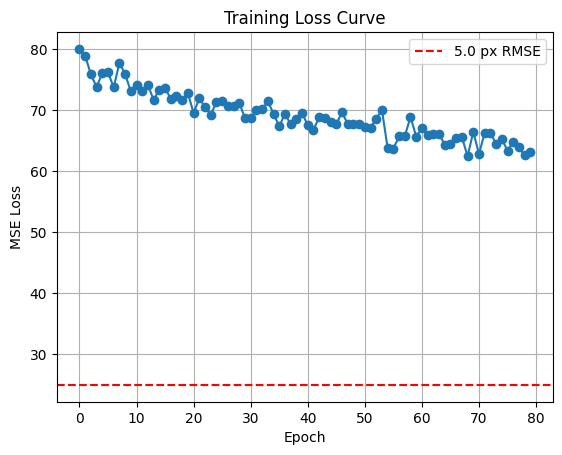

In [21]:
plt.plot(losses2, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.axhline(y=25, color='red', linestyle='--', label='5.0 px RMSE')
plt.legend()
plt.grid(True)
plt.show()

Test RMSE: 8.041 pixels


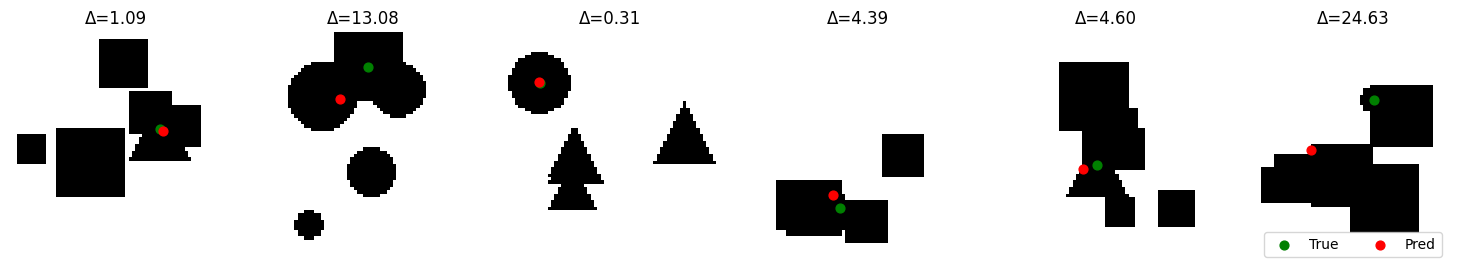

In [22]:
evaluate(model_v2, num_samples=1000)
visualize_predictions(model_v2, OddXYDataset(num_samples=6))

# **TEXTUAL DESCRIPTION**

The loss curve steadily decreases, indicating effective learning over time.
However, it plateaus well above the red dashed line, which marks the RMSE equivalent of 5.0 pixels (MSE ≈ 25). The final training loss hovers around 63–65, translating to an RMSE of around 7.9–8.1 pixels, which is not yet under the 5.0 px goal.

This suggests the model has learned some patterns but lacks sufficient complexity or training to reach the required precision.

From the visual representation we can see that each example shows the model’s predicted (red) and true (green) target points along with their pixel distance (Δ):

- Some examples are spot on (e.g., Δ = 0.31, 1.09), indicating strong local generalization.

- Others are way off (e.g., Δ = 13.08, 24.63), showing inconsistency or failure in difficult cases.


This variability indicates the model is not robust across all types of environments or object shapes. It could benefit from architectural improvements or better regularization.

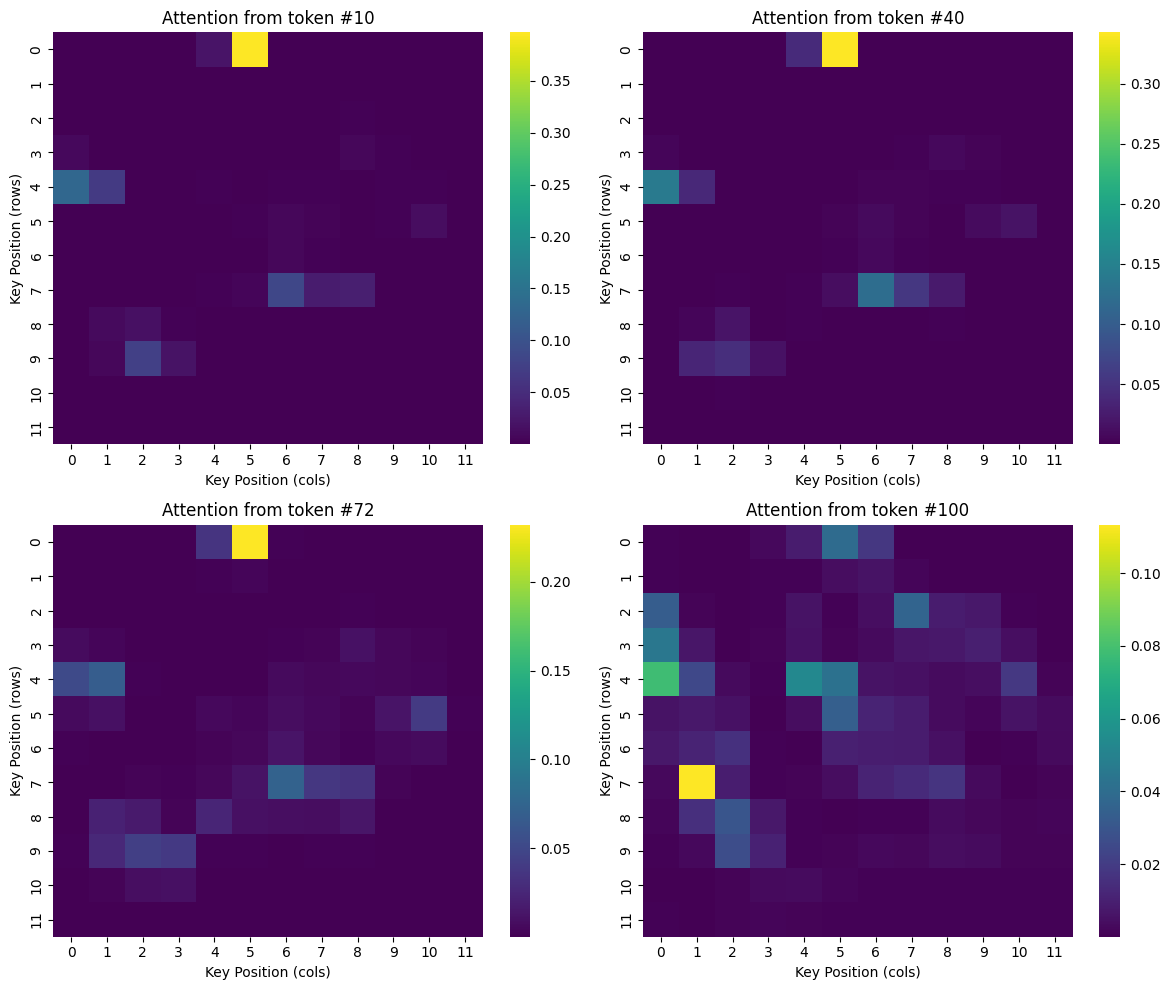

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_attention_maps(model, img_tensor, query_tokens=[10, 40, 72, 100]):
    """
    Plots attention heatmaps for given query tokens from the model's attention weights.

    Args:
        model: Trained model with .attn.attn_weights attribute.
        img_tensor: A [1, 1, 64, 64] torch.Tensor image input.
        query_tokens: List of token indices to visualize attention from.
    """
    model.eval()
    device = next(model.parameters()).device
    x_batch = img_tensor.to(device)  # Assume it's already [1, 1, 64, 64]

    # Forward pass (store attention weights in model.attn.attn_weights)
    with torch.no_grad():
        _ = model(x_batch)

    # Get attention weights of shape [1, 144, 144]
    attn_weights = model.attn.attn_weights.detach().cpu().squeeze(0)

    num_tokens = len(query_tokens)
    num_cols = 2
    num_rows = (num_tokens + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 6, num_rows * 5))
    for i, query_token in enumerate(query_tokens):
        plt.subplot(num_rows, num_cols, i + 1)
        heat = attn_weights[query_token].reshape(12, 12)  # Assuming 12x12 patch grid
        sns.heatmap(heat, cmap="viridis", cbar=True)
        plt.title(f"Attention from token #{query_token}")
        plt.xlabel("Key Position (cols)")
        plt.ylabel("Key Position (rows)")

    plt.tight_layout()
    plt.show()


dataset = OddXYDataset(num_samples=1)
img, label = dataset[0]  # img shape: [1, 64, 64]

# Add batch dimension: [1, 1, 64, 64]
img_tensor = img.unsqueeze(0)

plot_attention_maps(model, img_tensor, query_tokens=[10, 40, 72, 100])



#**KEY OBSERVATIONS BY TOKEN**

1. **Token #10 & #40**. <BR>
They show very peaked attention, especially to a token near the top-center (maybe position (0,5)). This means that those queries are relying heavily on a specific part of the image — maybe where the model noticed a significant or unusual shape.

2. **Token #72** <BR>
Attention is more spread out, still some focus in the top and central parts.
Suggests a more diffused representation, maybe trying to collect multiple signals (contextual clues from nearby regular shapes).

3. **Token #100** <BR>
Most diffuse of all four. Seems to attend more to lower and central-right regions. This may correspond to tokens that encode large or ambiguous patches, where the odd shape might be partially present.


In conclusion, these maps show how our model is reasoning spatiall, if a token (e.g. #72) is attending to specific regions, it's selecting which other parts of the image are important when making a decision.Futhermore, sharp attention (like #10) means confidence or reliance on a specific patch. Meanwhile, diffused attention (like #100) means uncertainty or combining features.

If the model consistently focuses on meaningful regions (e.g., where the odd shape is), it indicates successful spatial reasoning.

#**FINAL CONCLUSION**

In this project, we designed, trained, and evaluated transformer-based models for visual token classification to predict target locations in synthetic scenes. Despite achieving moderate success, our best model reached an RMSE of ~8 pixels, falling short of the 5-pixel benchmark required for full credit.